# Credit risk

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we'll create 3 models to assess credit risk by using:

- Logistic regression
- Random forests
- XGBoost

We'll find the best hyperparameters using cross-validation and randomized search.

Finally, we'll compare their performance with the various metrics we discussed in this section of the course.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.encoding import (
    RareLabelEncoder, 
    OrdinalEncoder, 
    OneHotEncoder,
)
from feature_engine.imputation import (
    ArbitraryNumberImputer, 
    CategoricalImputer, 
    MeanMedianImputer, 
    AddMissingIndicator,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split, 
    TunedThresholdClassifierCV,
)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    balanced_accuracy_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from xgboost import XGBClassifier

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings("ignore")

## Load data

For guidelines on how to obtain and prepare the data, check out section 2, or the folder called `datasets` in this repo.

In [2]:
df = pd.read_csv("../loan_data.csv", low_memory=False)

df.head()

,new_customer,income_verification,language,age,gender,country,amount,loan_duration,use_of_loan,education,...,credit_score_microL,credit_score_equifax,credit_score_fi_asiakas,credit_score_ee_mini,nr_previous_loans,amount_previous_loans,previous_repayments,previous_early_repayments,previous_early_repayments_count,default
0,0,expenses_verified,estonian,23,male,EE,5500.0,60,loan_consolidation,secondary,...,NaN,NaN,NaN,1000.0,1,3000.0,571.73,0.0,0,0
1,0,expenses_verified,russian,25,male,EE,1200.0,60,other,vocational,...,NaN,NaN,NaN,1000.0,1,500.0,194.98,0.0,0,0
2,1,verified,finnish,28,male,FI,2000.0,60,other,higher,...,NaN,NaN,RL2,NaN,0,0.0,0.00,0.0,0,0
3,1,unverified,finnish,49,female,FI,1000.0,60,other,basic,...,NaN,NaN,RL2,NaN,0,0.0,0.00,0.0,0,0
4,0,expenses_verified,estonian,25,female,EE,4100.0,60,loan_consolidation,secondary,...,NaN,NaN,NaN,1000.0,1,1500.0,1309.03,0.0,0,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("default", axis=1),
    df["default"],
    test_size=0.10,
    random_state=10,
)

X_train.shape, X_test.shape

((90589, 31), (10066, 31))

In [4]:
# Calculate the default rate in each data set

y_train.mean(), y_test.mean()

(0.1002881144509819, 0.09944367176634214)

## Feature engineering

We'll carry out different feature engineering steps for logistic regression and tree based models.

- For logistic regression we'll impute with the mean and add missing indicators. For tree based models we'll impute with an arbitrary number.

- For logistic regression we'll do one hot encoding, for tree based models, we'll carry out ordinal encoding.

Feature-engine transformers automatically identify numerical and categorical variables, so we don't need to worry too much here.

In [5]:
numerical_vars = [c for c in X_train.columns if df[c].dtype != "O"]

In [6]:
# set up individual feature engineering steps

missing_indicators = AddMissingIndicator(variables=numerical_vars)

imputer_mean = MeanMedianImputer()
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=-1)
imputer_categorical = CategoricalImputer()

rare_encoder = RareLabelEncoder(n_categories=2)
ordinal = OrdinalEncoder(encoding_method="arbitrary")
onehot = OneHotEncoder(drop_last=True)

## Set up pipelines

We'll set up feature engineering pipelines followed by the classifier.

In [7]:
logit = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(random_state=10)),
]
).set_output(transform="pandas")

In [8]:
rf = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(random_state=10))
]
).set_output(transform="pandas")

In [9]:
xgb = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(random_state=10))
]
).set_output(transform="pandas")

## Find best hyperparameters

We'll find the best model parameters using randomized search and cross-validation.

In [10]:
logit_params = {
    "model__C":[0.01, 0.1, 1, 10],
    "model__penalty":['l2', 'l1'],
}

search = RandomizedSearchCV(
    logit, 
    logit_params, 
    random_state=0,
    scoring = "roc_auc",
)
search.fit(X_train, y_train)

search.best_params_

{'model__penalty': 'l2', 'model__C': 0.1}

In [11]:
# best roc-auc value obtained

search.best_score_

0.6661850826850664

In [12]:
rf_params = {
    "model__n_estimators":[10, 50, 100, 500],
    "model__max_depth":[1, 2, 3, 4],
}

search = RandomizedSearchCV(
    rf, 
    rf_params, 
    random_state=0,
    scoring = "roc_auc",
)
search.fit(X_train, y_train)

search.best_params_

{'model__n_estimators': 100, 'model__max_depth': 4}

In [13]:
search.best_score_

0.7795485030792285

In [14]:
search = RandomizedSearchCV(
    xgb, 
    rf_params, 
    random_state=0,
    scoring = "roc_auc",
)
search.fit(X_train, y_train)

search.best_params_

{'model__n_estimators': 100, 'model__max_depth': 4}

In [15]:
search.best_score_

0.8296633338652925

## Optimized pipelines

In [16]:
logit = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(
        penalty = 'l2',
        C = 0.1, 
        random_state=10),
    ),
]).set_output(transform="pandas")


rf = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(
        n_estimators = 100,
        max_depth = 4, 
        random_state=10),
    )
]).set_output(transform="pandas")


xgb = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(
        n_estimators = 100,
        max_depth =  4,
        random_state=10),
    )
]).set_output(transform="pandas")

In [17]:
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=10, ...))])

## Evaluation

### ROC-AUC curves

#### Train set

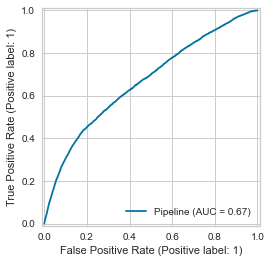

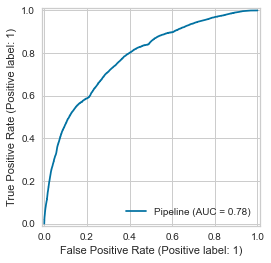

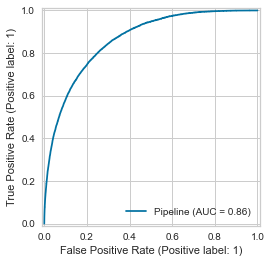

In [18]:
logit_roc = RocCurveDisplay.from_estimator(logit, X_train, y_train)
rf_roc = RocCurveDisplay.from_estimator(rf, X_train, y_train)
xgb_roc = RocCurveDisplay.from_estimator(xgb, X_train, y_train)

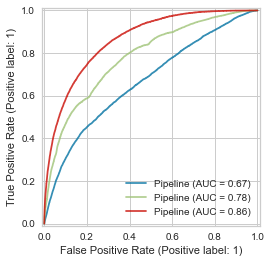

In [19]:
ax = plt.gca()
logit_roc.plot(ax=ax, alpha=0.8)
rf_roc.plot(ax=ax, alpha=0.8)
xgb_roc.plot(ax=ax, alpha=0.8)

#### Test set

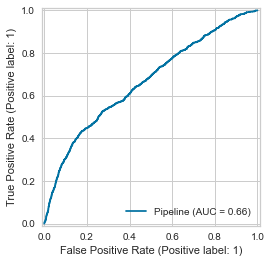

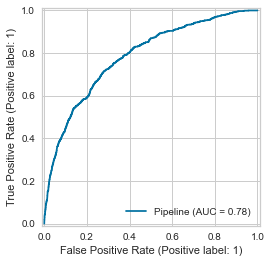

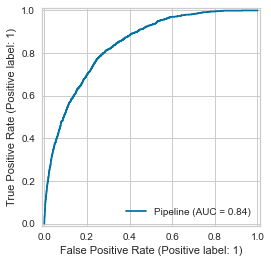

In [20]:
logit_roc = RocCurveDisplay.from_estimator(logit, X_test, y_test)
rf_roc = RocCurveDisplay.from_estimator(rf, X_test, y_test)
xgb_roc = RocCurveDisplay.from_estimator(xgb, X_test, y_test)

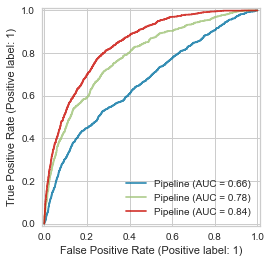

In [21]:
ax = plt.gca()
logit_roc.plot(ax=ax, alpha=0.8)
rf_roc.plot(ax=ax, alpha=0.8)
xgb_roc.plot(ax=ax, alpha=0.8)

The xgboost shows, as expected, the best performance, at least in terms of ROC-AUC.

Let's explore other metrics.

### Precision and recall curves

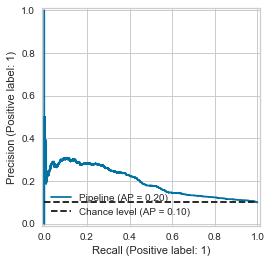

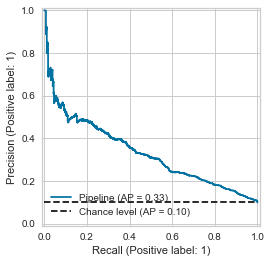

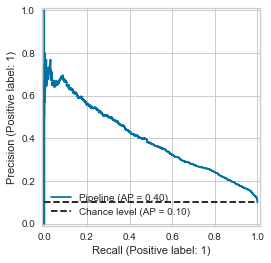

In [22]:
logit_prc = PrecisionRecallDisplay.from_estimator(logit, X_test, y_test, plot_chance_level=True)
rf_prc = PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, plot_chance_level=True)
xgb_prc = PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test, plot_chance_level=True)

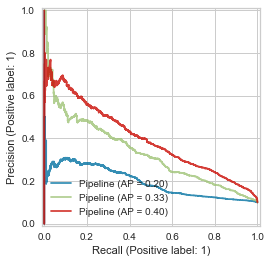

In [23]:
ax = plt.gca()
logit_prc.plot(ax=ax, alpha=0.8)
rf_prc.plot(ax=ax, alpha=0.8)
xgb_prc.plot(ax=ax, alpha=0.8)

As expected, the xgboost shows the best performance, followed by the random forest and last the logistic regression.

### Precision, Recall and f1-score

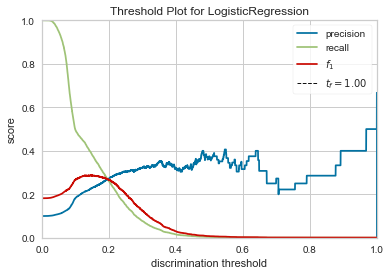

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [24]:
visualizer = DiscriminationThreshold(logit,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

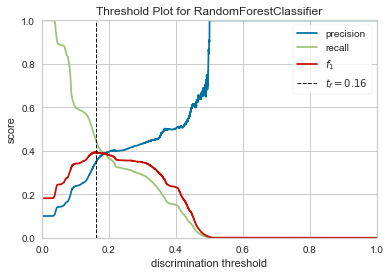

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [25]:
visualizer = DiscriminationThreshold(rf,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

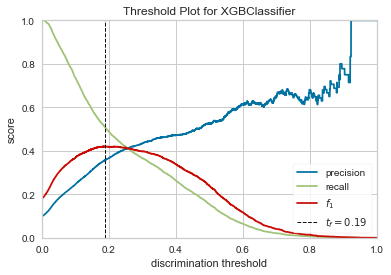

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [26]:
visualizer = DiscriminationThreshold(xgb,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

### Balanced accuracy

Let's calculate the balanced accuracy while finding the best threshold for this metric.

In [27]:
logit_tuned = TunedThresholdClassifierCV(
    logit, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

rf_tuned = TunedThresholdClassifierCV(
    rf, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

xgb_tuned = TunedThresholdClassifierCV(
    xgb, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

In [28]:
logit_tuned.best_threshold_

0.12302418994893587

In [29]:
rf_tuned.best_threshold_

0.08253443443459375

In [30]:
xgb_tuned.best_threshold_

0.0954185935430231

As expected, the optimal thresholds are much lower than the typical 0.5.

In [31]:
print('Balanced Accuracy Logistic Regression:', balanced_accuracy_score(y_test, logit_tuned.predict(X_test)))
print('Balanced Accuracy Random Forest:', balanced_accuracy_score(y_test, rf_tuned.predict(X_test)))
print('Balanced Accuracy xgb:', balanced_accuracy_score(y_test, xgb_tuned.predict(X_test)))

Balanced Accuracy Logistic Regression: 0.6264175978461692
Balanced Accuracy Random Forest: 0.7073987788273502
Balanced Accuracy xgb: 0.7624059338345053


From this notebook, we conclude that the xgboost model is the one with the best performance. 

The accuracy is not great. But we are probably most interested in the recall, because we want to identify those customers at higher risk of defaulting.

## Feature importance

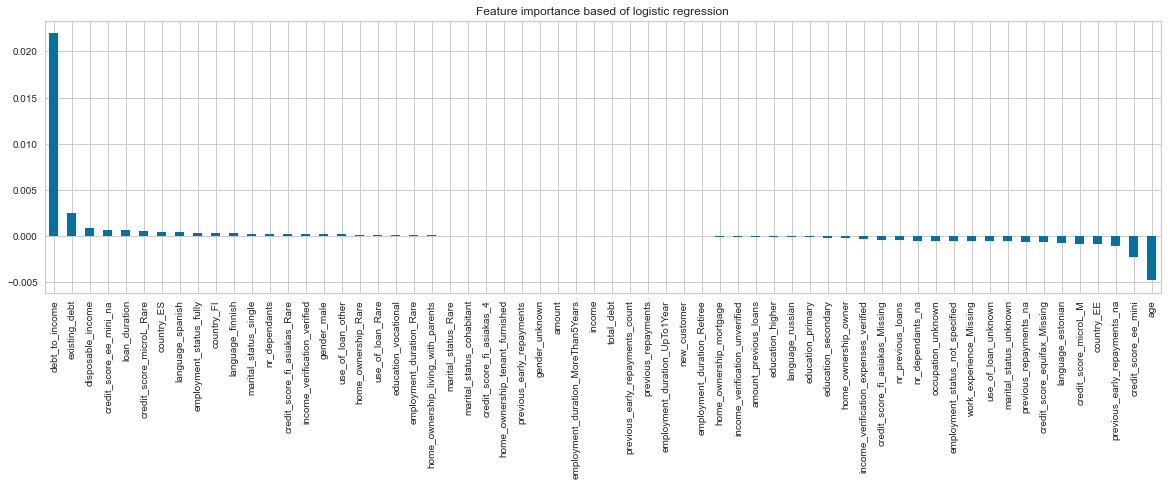

In [32]:
pd.Series(
    logit.named_steps["model"].coef_.ravel(),
    index = logit[:-1].get_feature_names_out(),
).sort_values(ascending=False).plot.bar(figsize=(20,5))
plt.title("Feature importance based of logistic regression")
plt.show()

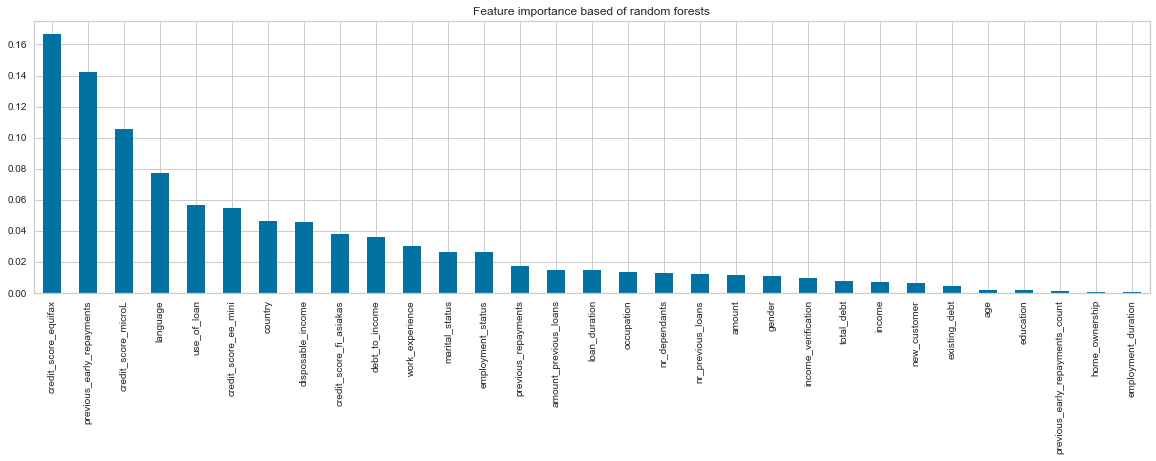

In [33]:
pd.Series(
    rf.named_steps["model"].feature_importances_,
    index = rf[:-1].get_feature_names_out(),
    ).sort_values(ascending=False).plot.bar(figsize=(20,5))
plt.title("Feature importance based of random forests")
plt.show()

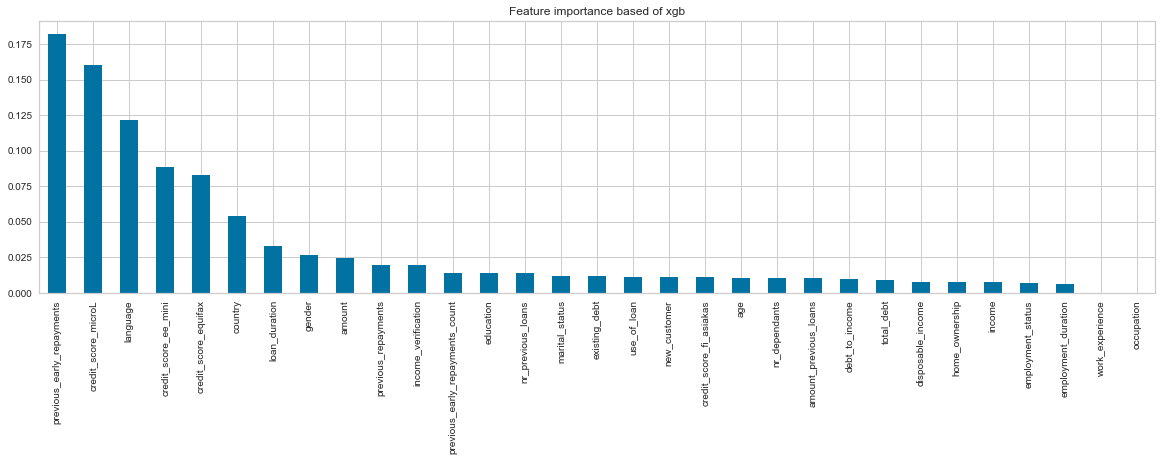

In [34]:
pd.Series(
    xgb.named_steps["model"].feature_importances_,
    index = xgb[:-1].get_feature_names_out(),
    ).sort_values(ascending=False).plot.bar(figsize=(20,5))
plt.title("Feature importance based of xgb")
plt.show()